In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import math

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

In [3]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
tar: Error opening archive: Failed to open 'aclImdb_v1.tar.gz'
'rm' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
'cat' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [4]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [7]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


In [8]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

a  bad  film  good  is  movie  this  very
0  0    0     0     1   1      1     1     1
1  1    0     1     1   1      0     1     0
2  0    2     0     0   0      0     0     3

In [10]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

a good  bad very  film is  is a  is very  movie is  this film  this movie  \
0       0         0        0     0        1         1          0           1   
1       1         0        1     1        0         0          1           0   
2       0         1        0     0        0         0          0           0   

   very bad  very good  very very  
0         0          1          0  
1         0          0          0  
2         2          0          1

# 【問題1】BoWのスクラッチ実装

In [117]:
mini_dataset = ['This movie is SOOOO funny!!!',
                'What a movie! I never',
                'best movie ever!!!!! this movie']

In [5]:
def scratch_bow(data, n=1):
    df = pd.DataFrame(index=np.arange(len(mini_dataset)))
    for i, sentence in enumerate(data):
        sentence = sentence.lower()
        words = re.split('\W+', sentence)
        if words[-1] == '':
            words.remove('')
        for j in range(len(words) - n + 1):
            bow = ' '.join(words[j:j+n])
            bow_list = []
            bow_list.append(bow)
            for word in bow_list:
                if word not in df.columns:
                    df[word] = 0
                df.loc[i, word] +=1
    df.sort_index(axis=1, inplace=True)
    
    return df

In [119]:
scratch_bow(mini_dataset, 1)

a  best  ever  funny  i  is  movie  never  soooo  this  what
0  0     0     0      1  0   1      1      0      1     1     0
1  1     0     0      0  1   0      1      1      0     0     1
2  0     1     1      0  0   0      2      0      0     1     0

In [120]:
scratch_bow(mini_dataset, 2)

a movie  best movie  ever this  i never  is soooo  movie ever  movie i  \
0        0           0          0        0         1           0        0   
1        1           0          0        1         0           0        1   
2        0           1          1        0         0           1        0   

   movie is  soooo funny  this movie  what a  
0         1            1           1       0  
1         0            0           0       1  
2         0            0           1       0

In [121]:
for i in mini_dataset:
    i = i.lower()
    i = re.split(r'(?u)\b\W+\b', i)
    print(i)

['this', 'movie', 'is', 'soooo', 'funny!!!']
['what', 'a', 'movie', 'i', 'never']
['best', 'movie', 'ever', 'this', 'movie']


In [122]:
for i in mini_dataset:
    i = i.lower()
    i = re.split(r'\W+', i)
    print(i)

['this', 'movie', 'is', 'soooo', 'funny', '']
['what', 'a', 'movie', 'i', 'never']
['best', 'movie', 'ever', 'this', 'movie']


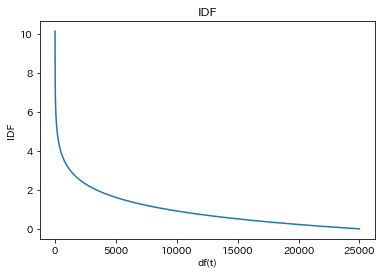

In [33]:
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

In [34]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

a  bad  film  good  movie  this  very
0  0    0     0     1      1     1     1
1  1    0     1     1      0     1     0
2  0    2     0     0      0     0     3

In [35]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shota\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

bad  good  is  this  very
0    0     1   1     1     1
1    0     1   1     1     0
2    2     0   0     0     3

# 【問題2】TF-IDFの計算

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
tfidfvectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000, norm=None)

In [58]:
tfidfvectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm=None, preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [59]:
X_train = tfidfvectorizer.transform(x_train)
X_test = tfidfvectorizer.transform(x_test)

In [67]:
df = pd.DataFrame(X_train.toarray() , columns=tfidfvectorizer.get_feature_names())
display(df)

00  000        10       100   11   12   13  13th        14   15  ...  \
0      0.0  0.0  0.000000  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
1      0.0  0.0  0.000000  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
2      0.0  0.0  2.998676  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
3      0.0  0.0  2.998676  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
4      0.0  0.0  0.000000  0.000000  0.0  0.0  0.0   0.0  5.869176  0.0  ...   
...    ...  ...       ...       ...  ...  ...  ...   ...       ...  ...  ...   
24995  0.0  0.0  0.000000  5.127735  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
24996  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
24997  0.0  0.0  2.998676  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
24998  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   
24999  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0   0.0  0.000000  0.0  ...   

            yet      york     young  younger  youth     zero  zizek  zombie  \
0      0.000000  0.000000  6.437303      0.0    0.0  5.35835    0.0     0.0   
1      0.000000  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   
2      0.000000  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   
3      0.000000  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   
4      0.000000  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   
...         ...       ...       ...      ...    ...      ...    ...     ...   
24995  0.000000  9.393903  0.000000      0.0    0.0  0.00000    0.0     0.0   
24996  3.397815  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   
24997  0.000000  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   
24998  3.397815  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   
24999  3.397815  0.000000  0.000000      0.0    0.0  0.00000    0.0     0.0   

       zombies  zone  
0          0.0   0.0  
1          0.0   0.0  
2          0.0   0.0  
3          0.0   0.0  
4          0.0   0.0  
...        ...   ...  
24995      0.0   0.0  
24996      0.0   0.0  
24997      0.0   0.0  
24998      0.0   0.0  
24999      0.0   0.0  

[25000 rows x 5000 columns]

# 【問題3】TF-IDFを用いた学習

In [64]:
# 語彙数:5000、ストップワード:ntlk、n-gram:(1,1)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('accuracy_score:{}'.format(accuracy_score(y_test, y_pred)))

accuracy_score:0.81228


# 【問題4】TF-IDFのスクラッチ実装

## 標準的な式

In [129]:
def scrach_tf_idf(data, n=1):
    num_data = len(data)
    df = scratch_bow(data, n)
    df_tf_idf = df.copy()
    for i in range(num_data):
        for word in df.columns:
            term_frequency = df.loc[i, word]/sum(df.loc[i])
            inverse_document_frequency = math.log(num_data/sum(df[word]>0))
            df_tf_idf.loc[i, word] = term_frequency*inverse_document_frequency
            
    return df_tf_idf

In [133]:
scrach_tf_idf(mini_dataset)

a      best      ever     funny         i        is  movie  \
0  0.000000  0.000000  0.000000  0.219722  0.000000  0.219722    0.0   
1  0.219722  0.000000  0.000000  0.000000  0.219722  0.000000    0.0   
2  0.000000  0.219722  0.219722  0.000000  0.000000  0.000000    0.0   

      never     soooo      this      what  
0  0.000000  0.219722  0.081093  0.000000  
1  0.219722  0.000000  0.000000  0.219722  
2  0.000000  0.000000  0.081093  0.000000

## scikit-learnの採用している式

In [140]:
def scrach_sklearn_tf_idf(data, n=1):
    num_data = len(data)
    df = scratch_bow(data, n)
    df_tf_idf = df.copy()
    for i in range(num_data):
        for word in df.columns:
            term_frequency = df.loc[i, word]
            inverse_document_frequency = math.log((1+num_data)/(1+sum(df[word]>0))) + 1
            df_tf_idf.loc[i, word] = term_frequency*inverse_document_frequency
            
    return df_tf_idf

In [141]:
scrach_sklearn_tf_idf(mini_dataset)

a      best      ever     funny         i        is  movie  \
0  0.000000  0.000000  0.000000  1.693147  0.000000  1.693147    1.0   
1  1.693147  0.000000  0.000000  0.000000  1.693147  0.000000    1.0   
2  0.000000  1.693147  1.693147  0.000000  0.000000  0.000000    2.0   

      never     soooo      this      what  
0  0.000000  1.693147  1.287682  0.000000  
1  1.693147  0.000000  0.000000  1.693147  
2  0.000000  0.000000  1.287682  0.000000

# 【問題5】コーパスの前処理

In [6]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.02015119  0.01130365 -0.03383154 -0.02023723 -0.02244372  0.00832
 -0.01273143 -0.04400842 -0.02224804 -0.01484937]
movieのベクトル : 
[-0.00327645 -0.03256989  0.00427055 -0.02640067 -0.01747683 -0.02714498
  0.04866704  0.00206281  0.02440668  0.02782195]
isのベクトル : 
[ 0.03278178  0.02203645  0.00485166  0.00750822  0.01457155 -0.02286
 -0.00308408 -0.03467933 -0.02848723  0.0049703 ]
veryのベクトル : 
[ 0.02773513  0.01897007 -0.00408642  0.00687215 -0.0112915   0.01209838
  0.02886263 -0.01447884 -0.03760151  0.02264421]
goodのベクトル : 
[ 0.01367699 -0.01420955  0.01886909  0.00094291  0.03183552 -0.03626815
  0.04847766 -0.00078616 -0.00893771  0.02971161]
filmのベクトル : 
[-0.01060069  0.02000296  0.04126879 -0.0211742  -0.0162066  -0.02339413
 -0.04303412  0.03679535 -0.00825938 -0.01542656]
aのベクトル : 
[ 0.02892631  0.02108258 -0.0457083   0.04417313  0.00782797 -0.03009741
  0.00768336 -0.0450654  -0.0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [7]:
model.wv.most_similar(positive="good", topn=3)

[('movie', 0.5969773530960083),
 ('bad', 0.39626002311706543),
 ('is', 0.33990687131881714)]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


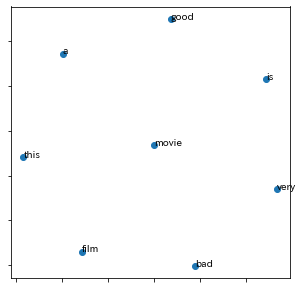

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [9]:
def separate_words(data):
    data_list = []
    for sentence in data:
        words = re.split('\W+', sentence)
        if words[-1] == '':
            words.remove('')
        words_list = []
        for word in words:
            word = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', word)
            words_list.append(word)
        data_list.append(words_list)
    
    return data_list

In [109]:
X_train = separate_words(x_train)
X_train

[['Zero',
  'Day',
  'leads',
  'you',
  'to',
  'think',
  'even',
  're',
  'think',
  'why',
  'two',
  'boys',
  'young',
  'men',
  'would',
  'do',
  'what',
  'they',
  'did',
  'commit',
  'mutual',
  'suicide',
  'via',
  'slaughtering',
  'their',
  'classmates',
  'It',
  'captures',
  'what',
  'must',
  'be',
  'beyond',
  'a',
  'bizarre',
  'mode',
  'of',
  'being',
  'for',
  'two',
  'humans',
  'who',
  'have',
  'decided',
  'to',
  'withdraw',
  'from',
  'common',
  'civility',
  'in',
  'order',
  'to',
  'define',
  'their',
  'own',
  'mutual',
  'world',
  'via',
  'coupled',
  'destruction',
  'br',
  'br',
  'It',
  'is',
  'not',
  'a',
  'perfect',
  'movie',
  'but',
  'given',
  'what',
  'money',
  'time',
  'the',
  'filmmaker',
  'and',
  'actors',
  'had',
  'it',
  'is',
  'a',
  'remarkable',
  'product',
  'In',
  'terms',
  'of',
  'explaining',
  'the',
  'motives',
  'and',
  'actions',
  'of',
  'the',
  'two',
  'young',
  'suicide',
  'murde

# 【問題6】Word2Vecの学習

In [11]:
sentences = X_train
model = Word2Vec(min_count=1, size=100) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


(23249887, 30289680)

In [12]:
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))

語彙の一覧 : dict_keys(['Zero', 'Day', 'leads', 'you', 'to', 'think', 'even', 're', 'why', 'two', 'boys', 'young', 'men', 'would', 'do', 'what', 'they', 'did', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'It', 'captures', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'humans', 'who', 'have', 'decided', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'define', 'own', 'world', 'coupled', 'destruction', 'br', 'is', 'not', 'perfect', 'movie', 'but', 'given', 'money', 'time', 'the', 'filmmaker', 'and', 'actors', 'had', 'it', 'remarkable', 'product', 'In', 'terms', 'explaining', 'motives', 'actions', 'murderers', 'better', 'than', 'Elephant', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'far', 'almost', 'anything', 'are', 'likely', 'see', 'Flawed', 'honest', 'with', 'terrible', 'honesty', 'Words', 'can', 't', 'describe', 'how', 'bad', 'this', 'I', 'explain', 'by', 'writing', 'only', 'You', 'too', 'yourself', 'ge

In [13]:
print("{}のベクトル : \n{}".format('good', model.wv['good']))

goodのベクトル : 
[ 2.48509     0.07946675 -0.86364573 -2.3399038  -0.08917508 -1.4416032
  4.0560727   1.5035101  -0.2693969  -2.7338657   0.44281498 -0.89497674
  1.0272503   2.0419054  -1.5291878   0.00561895 -1.8014828   0.70551354
 -0.02687891  4.3477426   0.17594974  1.6988978   3.0382586   2.5009165
  2.2729201  -0.8409244   0.15767053  1.4550861   1.1746302  -0.18649551
 -0.13216017 -1.8902633   1.1176622  -1.2270318   3.3440468   1.0173694
  1.4109844   1.9001297   0.2485034   0.16874321  1.3736349   3.9952617
 -0.44562602 -2.2840142   4.623837    2.3442037   0.42406344  1.1296672
  0.48444     2.3740673  -1.5369575  -2.2914453  -1.96985     0.2387556
  0.93247074 -1.1416348  -2.7919207  -2.1360183  -0.66784847  0.6924299
 -2.992398   -0.88446283 -3.248276   -0.8911284   1.602587    1.4522752
  1.3110385   2.090214    1.513667    3.309302   -0.7963386   0.6649934
  2.2050533   0.80087805 -1.2112103   0.6759739  -2.4906168  -0.02477661
 -0.11115786  1.5598077  -1.0033274   1.3966067

# 【問題7】（アドバンス課題）ベクトルの可視化

In [21]:
list(model.wv.vocab.keys())[:10]

['Zero', 'Day', 'leads', 'you', 'to', 'think', 'even', 're', 'why', 'two']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


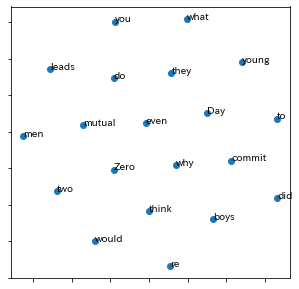

In [27]:
vocabs = list(model.wv.vocab.keys())[:20]
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [25]:
print('good:{}'.format(model.wv.most_similar(positive="good", topn=3)))
print('drink:{}'.format(model.wv.most_similar(positive="drink", topn=3)))
print('television:{}'.format(model.wv.most_similar(positive="television", topn=3)))

good:[('decent', 0.7563068866729736), ('great', 0.7485265731811523), ('bad', 0.7323086857795715)]
drink:[('smoke', 0.8246921300888062), ('drop', 0.7824930548667908), ('coffee', 0.7757736444473267)]
television:[('TV', 0.9050692915916443), ('tv', 0.7661558985710144), ('BBC', 0.7376493215560913)]
